# 프로젝트명: 불균형 데이터 처리 실습 (SMOTE 오버샘플링)



![오버샘플링](https://firebasestorage.googleapis.com/v0/b/ls-storage-e452a.appspot.com/o/%E1%84%8B%E1%85%A9%E1%84%87%E1%85%A5%E1%84%89%E1%85%A2%E1%86%B7%E1%84%91%E1%85%B3%E1%86%AF%E1%84%85%E1%85%B5%E1%86%BC1.png?alt=media&token=1925ebc6-a322-465d-99c7-2405fb16d362)

#### 📌 SMOTE (Synthetic Minority Over-sampling Technique) 방법
- 소수인 데이터에 K근접 이웃을 찾아서, 무작위로 이웃을 선택합니다.
- 그리고 선택한 이웃 사이에 가상의 데이터를 생성합니다. 


#### 🚨 주의사항
- SMOTE를 적용한다고 무조건 모델의 성능이 좋아지는 게 아닙니다.
- 정상: 99.9% / 비정상 0.1% 처럼 극히 불균형한 데이터셋에 적용하지만, 노이즈가 있는 데이터라면 오히려 노이즈가 증가할 수 있습니다.

![SMOTE](https://firebasestorage.googleapis.com/v0/b/ls-storage-e452a.appspot.com/o/%E1%84%8B%E1%85%A9%E1%84%87%E1%85%A5%E1%84%89%E1%85%A2%E1%86%B7%E1%84%91%E1%85%B3%E1%86%AF%E1%84%85%E1%85%B5%E1%86%BC2.png?alt=media&token=71e91018-7498-4242-b491-498e3c55e921)

#### 실습 데이터 : 신용카드 사기 데이터 

- 정상 클래스 : 99.8%
- 비정상 클래스 : 0.02%
- Amount : 금액 (유로화)
- Class : 사기 여부 (정상:0, 사기:1)


### 분석 과정

1. 중요 변수의 분포도 변경 (리스케일)
> - ✅ Log 변환: Skew(왜도)가 심한 분포를 `정규분포`처럼 바꿔주는 변환 방법
> - ✅ 정규분포로 바꾸는 이유 : 대부분 ML알고리즘은 정규분포일 때 성능이 좋아지기 때문 (트리기반 알고리즘에는 효과 미미)
2. 이상치 제거
> - ✅ 이상치가 있으면 모델 성능이 저하될 수 있음 (안 될 수도 있고)
3. SMOTE 오버 샘플링
> - ✅ 사기 데이터 뻥튀기 시킴
4. 모델 학습 및 성능 비교
> - 로지스틱 회귀모델, LightGBM 대상

In [25]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

#### 데이터는 캐글의 신용카드 사기검출 데이터를 사용해주세요.
- https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


In [26]:
data = pd.read_csv("https://firebasestorage.googleapis.com/v0/b/ls-storage-e452a.appspot.com/o/creditcard.csv?alt=media&token=619cfdf2-6e90-4fd1-a732-035b0417227f")


In [1]:
data['Class'].value_counts(), data['Class'].value_counts(normalize=True)

NameError: name 'data' is not defined

In [28]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 1. 계속사용할 코드를 함수로 생성

In [5]:
## 1. 전처리 함수 (앞으로 계속 로직이 추가될 예정)
def clean_data(df):
    df_copy = df.copy()
    df_copy = df_copy.drop(['Time'], axis=1)
    return df_copy

## 2. 데이터 분리 함수
def get_train_test_dataset(df):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = clean_data(df)
    # DataFrame의 맨 마지막 컬럼이 종속변수, 나머지는 독립변수
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]

    ## train_test_split()으로 학습과 테스트 데이터 분할.
    ## stratify=y_target으로 Stratified 기반 분할.
    X_train, X_test, y_train, y_test = train_test_split(X_features, 
                                                        y_target, 
                                                        test_size=0.3, 
                                                        random_state=0, 
                                                        stratify=y_target 
                                                        )
    return X_train, X_test, y_train, y_test

## 3. 모델성능 평가 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('========= 오차 행렬 ========= ')
    print(confusion)
    print('=========================== ')

    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    ⭐️F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## 4. 모델 학습 및 평가 함수
def get_model_train_eval(model, X_feature_train=None, X_feature_test=None, Y_feature_train=None, Y_feature_test=None):
    model.fit(X_feature_train, Y_feature_train)
    pred = model.predict(X_feature_test)
    pred_proba = model.predict_proba(X_feature_test)[:, 1]
    get_clf_eval(Y_feature_test, pred, pred_proba)


### 2. 학습데이터와 테스트 데이터의 종속변수 비율 확인하기

In [6]:
X_train, X_test, y_train, y_test = get_train_test_dataset(data)

print('학습 데이터 레이블 값 비율')
print(y_train.value_counts(normalize=True))
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts(normalize=True))

학습 데이터 레이블 값 비율
0    0.998275
1    0.001725
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    0.998268
1    0.001732
Name: Class, dtype: float64


### 3. 로지스틱 회귀모델 

In [7]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression() ## 로지스틱 회귀로 모델 생성
lr_clf.fit(X_train, y_train) ## 학습
lr_pred = lr_clf.predict(X_test) ## 예측
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)

========= 오차 행렬 ========= 
[[85279    16]
 [   58    90]]
정확도: 0.9991, 정밀도: 0.8491, 재현율: 0.6081,    ⭐️F1: 0.7087, AUC:0.9536


### 4. LightGBM 모델
##### 🚨 불균형 데이터를 LightGBM 사용시, `boost_from_average=False`를 무조건 해줘야합니다.
- 안 그러면, 성능이 저하됩니다.

In [8]:
lgbm_clf = LGBMClassifier(n_estimators=1000, 
                          num_leaves=64, 
                          n_jobs=-1, 
                          boost_from_average=False
                          )

get_model_train_eval(lgbm_clf, X_feature_train=X_train, X_feature_test=X_test, Y_feature_train=y_train, Y_feature_test=y_test)


[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

### 5. 중요 변수인 Amount 변수의 분포 변경 후 모델 성능 평가
##### Amount 분포 확인

##### ⭐️ TIP. 매출액, 소득, 금액 같은 변수들은 보통 Skew(왜도)가 심한 경우가 많습니다.

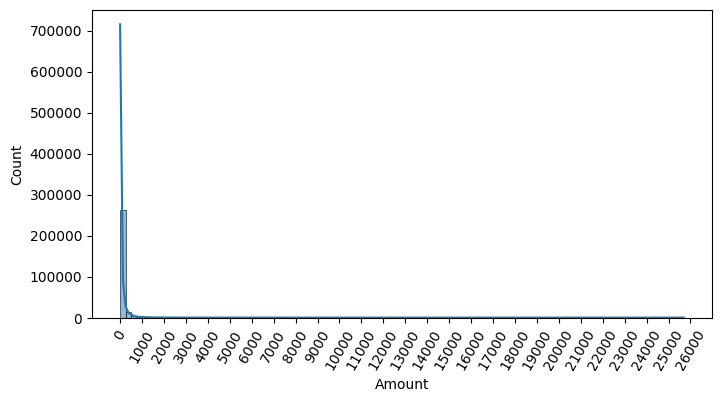

In [9]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(data['Amount'], bins=100, kde=True)
plt.show()

- 경험적으로 Skew가 심한 데이터는 StandardScaler 보다 Log 스케일이 좀 더 성능이 좋습니다. 
### 6. 전처리 함수에 StandardScaler 추가

In [10]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def clean_data(df):
    df_copy = df.copy()
    print("🔥StandardScaler 실행중...")
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

##### 리스케일 후 성능 비교

In [11]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(data)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_feature_train=X_train, X_feature_test=X_test, Y_feature_train=y_train, Y_feature_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_feature_train=X_train, X_feature_test=X_test, Y_feature_train=y_train, Y_feature_test=y_test)


🔥StandardScaler 실행중...
### 로지스틱 회귀 예측 성능 ###
========= 오차 행렬 ========= 
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    ⭐️F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

#### StandardScaler 적용 후 성능 비교
##### 로지스틱 회귀모델 
- 원본데이터 => 정확도: 0.9991, 정밀도: 0.8491, 재현율: 0.6081,    ⭐️F1: 0.7087, AUC:0.9536
- 리스케일 데이터 => 정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    ⭐️F1: 0.7143, AUC:0.9702
-----------------------
##### LightGBM 
- 원본데이터 => 정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    ⭐️F1: 0.8453, AUC:0.9790
- 리스케일 데이터 => 정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    ⭐️F1: 0.8409, AUC:0.9779

#### ✅ 리스케일을 진행한다고 해서 성능이 반드시 좋아지지 않습니다.

### 7. 전처리 함수에 로그스케일 추가

In [12]:
import numpy as np
def clean_data(df):
    df_copy = df.copy()
    print("🔥로그 변환 실행중...")
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    # ⭐️ log1p()는 넘파이의 log() 함수와 유사하나 log(0)은 무한대가 되지만 log1p(0)은 0으로 반환
    # ⭐️⭐️복원시에는 np.expm1()을 이용한다.
    amount_n = np.log1p(df_copy['Amount']) 
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy


##### 로그변환 뒤 성능비교

In [13]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(data)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_feature_train=X_train, X_feature_test=X_test, Y_feature_train=y_train, Y_feature_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_feature_train=X_train, X_feature_test=X_test, Y_feature_train=y_train, Y_feature_test=y_test)

🔥로그 변환 실행중...
### 로지스틱 회귀 예측 성능 ###
========= 오차 행렬 ========= 
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    ⭐️F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

#### 로그변환 적용 후 성능 비교
##### 로지스틱 회귀모델 
- 원본데이터 => 정확도: 0.9991, 정밀도: 0.8491, 재현율: 0.6081,    ⭐️F1: 0.7087, AUC:0.9536 
- 리스케일 데이터 => 정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    ⭐️F1: 0.7149, AUC:0.9727
-----------------------
##### LightGBM 
- 원본데이터 => 정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    ⭐️F1: 0.8453, AUC:0.9790
- 리스케일 데이터 => 정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    ⭐️F1: 0.8496, AUC:0.9796

#### ✅ 리스케일을 진행한다고 해서 성능이 반드시 좋아지지 않지만, 조금 증가함. 

### 8. Amount에 로그변환 후 분포 시각화

In [14]:
X_train.head()

,Amount_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
211605,0.524729,-8.367621,7.402969,-5.114191,-2.966792,-0.985904,-1.660018,0.397816,1.008250,5.290976,...,-0.750795,3.589299,-0.557927,0.349087,0.301734,0.662330,1.145939,-0.012273,1.513736,0.669504
231628,4.033710,-1.290662,0.764452,-0.169233,-1.688528,1.984718,-0.717210,1.667635,-0.228295,-0.959071,...,-0.059595,0.057620,0.138615,0.390374,-0.678774,0.292254,1.425865,0.265341,0.051405,0.103879
110643,2.525729,-0.606860,0.233923,2.633361,-0.155762,-0.328850,-0.070593,0.173023,0.113394,0.680147,...,-1.003842,-0.129287,0.007393,0.265045,-0.040615,0.406088,-0.498823,0.121851,-0.046840,-0.087259
11478,2.397895,1.374168,-0.330389,0.812971,-0.183112,-1.074771,-0.933788,-0.544238,-0.348237,0.614925,...,0.603330,0.078163,-0.134742,0.016793,0.002610,0.714527,0.536175,-0.307487,-0.003555,0.013024
243724,7.736766,-2.146505,-7.603113,-4.928224,1.449173,-2.083871,-0.984759,3.629816,-1.302973,-1.434148,...,-1.373723,4.009181,1.274986,-0.857670,-2.109682,0.169338,-0.322888,0.777822,-0.552258,0.304777


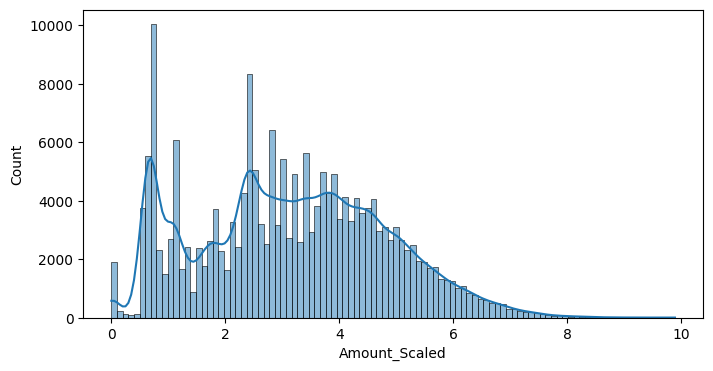

In [15]:
plt.figure(figsize=(8, 4))
sns.histplot(X_train['Amount_Scaled'], bins=100, kde=True)
plt.show()

### 9. 이상치 데이터 제거 후 모델 성능 비교

##### 분석절차
1. 변수들끼리 상관관계 분석 진행
2. 종속변수와 연관있는 변수 추출

<AxesSubplot:>

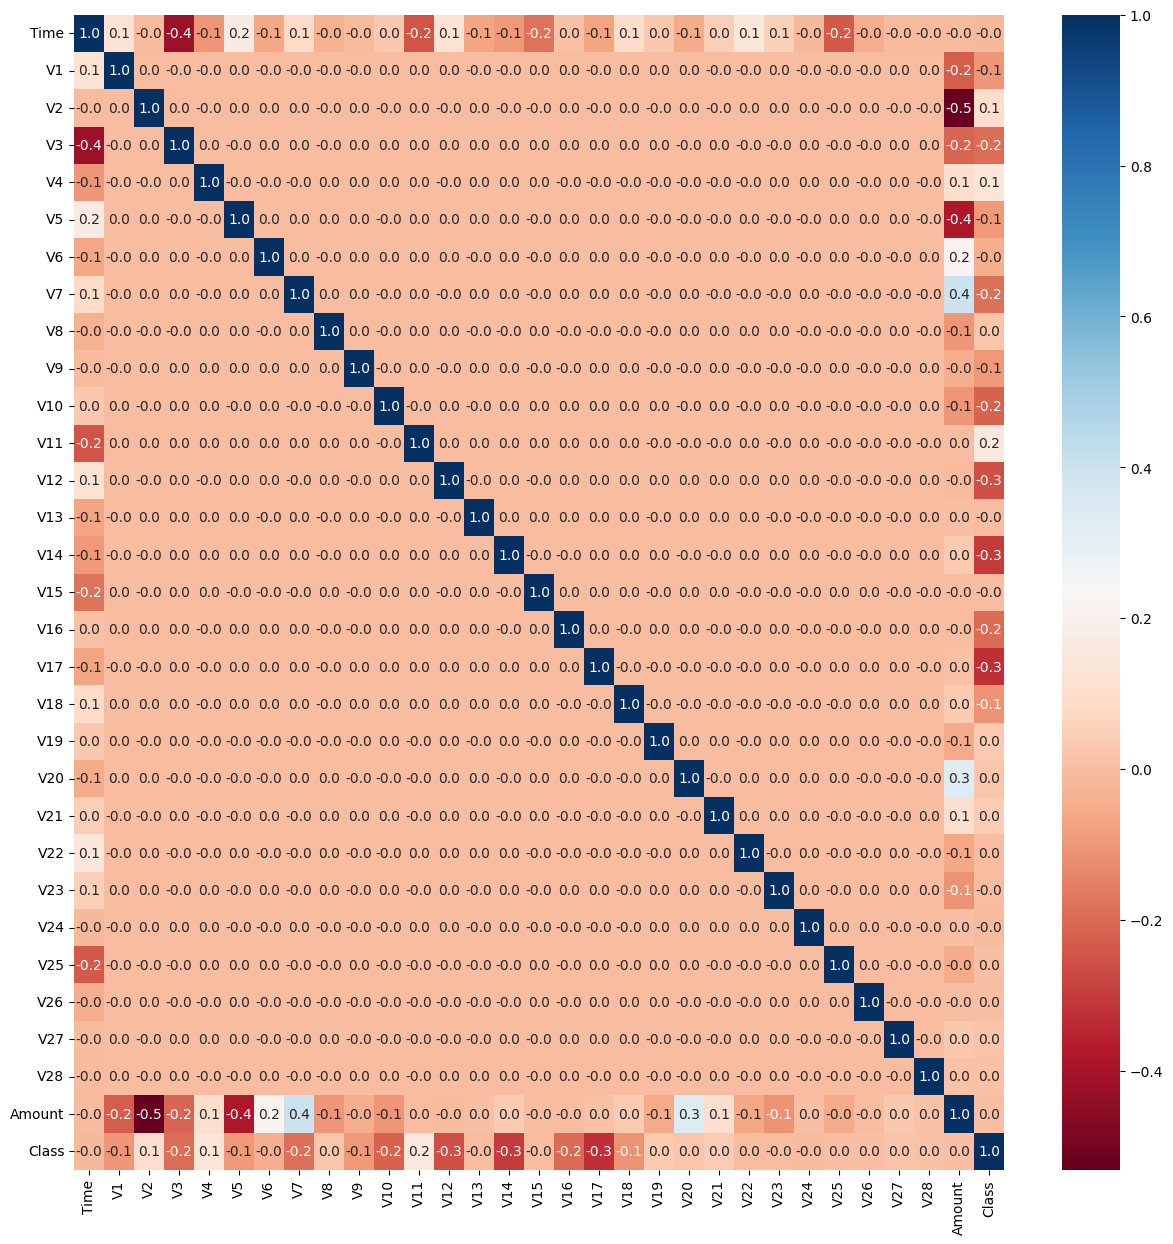

In [16]:
import seaborn as sns

plt.figure(figsize=(15, 15))
corr = data.corr()
sns.heatmap(corr, cmap='RdBu', annot=True, fmt='.1f')

### 10. 종속변수와 연관있는 변수 중 V14를 대상으로 이상치 찾아보자.

![IQR_이상치제거](https://firebasestorage.googleapis.com/v0/b/ls-storage-e452a.appspot.com/o/%E1%84%8B%E1%85%B5%E1%84%89%E1%85%A1%E1%86%BC%E1%84%8E%E1%85%B5%E1%84%8C%E1%85%A6%E1%84%80%E1%85%A5_IQR.png?alt=media&token=12c9c471-769d-4d4e-b1df-34c6011eed22)

- IQR 방식은 가장 보편적인 이상치 제거 방법입니다.

In [17]:
data['V14'].describe()

count    2.848070e+05
mean     1.207294e-15
std      9.585956e-01
min     -1.921433e+01
25%     -4.255740e-01
50%      5.060132e-02
75%      4.931498e-01
max      1.052677e+01
Name: V14, dtype: float64

In [18]:
print(np.percentile(data['V14'].values, 0),
       np.percentile(data['V14'].values, 25), 
       np.percentile(data['V14'].values, 50),
       np.percentile(data['V14'].values, 75), 
       np.percentile(data['V14'].values, 100)
)

-19.2143254902614 -0.4255740124549935 0.0506013193100486 0.493149849218149 10.5267660517847


In [19]:
def get_outlier(df, column, weight=1.5):
    # 사기에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 이상치로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index


In [20]:
V14_outliers = get_outlier(data, 'V14', weight=1.5)
V14_outliers


Int64Index([8296, 8615, 9035, 9252], dtype='int64')

### 11. 로그변환 전처리 함수에 이상치 제거 로직 추가

In [21]:
def clean_data(df):
    df_copy = df.copy()
    print("🔥로그 변환 실행중...")
    amount_n = np.log1p(df_copy['Amount']) 
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    print("🔥이상치 제거 실행중...")
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy


In [22]:
X_train, X_test, y_train, y_test = get_train_test_dataset(data)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_feature_train=X_train, X_feature_test=X_test, Y_feature_train=y_train, Y_feature_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_feature_train=X_train, X_feature_test=X_test, Y_feature_train=y_train, Y_feature_test=y_test)

🔥로그 변환 실행중...
🔥이상치 제거 실행중...
### 로지스틱 회귀 예측 성능 ###
========= 오차 행렬 ========= 
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    ⭐️F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

#### 로그변환 적용 + V14 이상치 제거 성능 비교
##### 로지스틱 회귀모델 
- 원본데이터  .  .  .  .  .  .  .  .  .  .  .  .  .  . . => 정확도: 0.9991, 정밀도: 0.8491, 재현율: 0.6081,    ⭐️F1: 0.7087, AUC:0.9536 
- 리스케일 & 이상치 제거 데이터 => 정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    ⭐️F1: 0.7597, AUC:0.9743
-----------------------
##### LightGBM 
- 원본데이터  .  .  .  .  .  .  .  .  .  .  .  .  .  . . => 정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    ⭐️F1: 0.8453, AUC:0.9790
- 리스케일 & 이상치 제거 데이터 => 정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    ⭐️F1: 0.8897, AUC:0.9780

#### ✅ 리스케일을 진행하고, 이상치를 지우니 성능이 많이 좋아졌다!

##### ⭐️ 이상치를 지울때 유의사항
> - 1. 모델에 성능에 집중해서 이상치 제거에 중독되는데, 사실 이상치를 덜 지워야하는게 좋습니다. 
> - 2. 현실에서 신규 데이터 유입시 제거했던 그 `이상치 데이터`가 들어올 수 있기 때문입니다. 

### 12. SMOTE 오버 샘플링 후 모델 성능 비교

%pip install -U imbalanced-learn


#### 🚨 주의사항
1. 모델 `학습`만 SMOTE 시킨 데이터를 사용해야합니다.
2. 테스트셋은 미리 분리한 데이터를 사용해야만 합니다.

In [23]:
from imblearn.over_sampling import SMOTE

## 1. SMOTE 정의
smote = SMOTE(random_state=0)
## 2. SMOTE 적용
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print('SMOTE 적용 🔴전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 🟢후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts(), '\n', pd.Series(y_train_over).value_counts(normalize=True))

SMOTE 적용 🔴전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 🟢후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64 
 0    0.5
1    0.5
Name: Class, dtype: float64


In [24]:
print('### SMOTE 데이터의 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, 
                     X_feature_train=X_train_over, 
                     X_feature_test=X_test, ## ✅ 테스트 데이터는 그대로 사용
                     Y_feature_train=y_train_over, 
                     Y_feature_test=y_test ## ✅ 테스트 데이터는 그대로 사용
                     )

print('### SMOTE 데이터의 LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, 
                     X_feature_train=X_train_over, 
                     X_feature_test=X_test, ## ✅ 테스트 데이터는 그대로 사용
                     Y_feature_train=y_train_over, 
                     Y_feature_test=y_test ## ✅ 테스트 데이터는 그대로 사용
                     )

### SMOTE 데이터의 로지스틱 회귀 예측 성능 ###
========= 오차 행렬 ========= 
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    ⭐️F1: 0.1023, AUC:0.9737
### SMOTE 데이터의 LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

#### 로그변환 적용 + V14 이상치 제거 + SMOTE 성능 비교
##### 로지스틱 회귀모델 
- 원본데이터  .  .  .  .  .  .  .  .  .  .  .  .  .  . .  .  . ..  . .  .  . . => 정확도: 0.9991, 정밀도: 0.8491, 재현율: 0.6081,    ⭐️F1: 0.7087, AUC:0.9536 
- 리스케일 & 이상치 제거 & SMOTE 데이터 => 정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    ⭐️F1: 0.1023, AUC:0.9737
-----------------------
##### LightGBM 
- 원본데이터  .  .  .  .  .  .  .  .  .  .  .  .  .  . .  .  . ..  . .  .  . . => 정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    ⭐️F1: 0.8453, AUC:0.9790
- 리스케일 & 이상치 제거 & SMOTE 데이터 => 정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    ⭐️F1: 0.8794, AUC:0.9814

- ✅ 로지스틱 회귀모델: 재현율은 많이 좋아졌지만, 나머지 성능은 안 좋아졌다. SMOTE를 사용한다고 해서 반드시 개선되지는 않는다.
> - 정밀도가 너무 낮아, 사용하기 어렵다.
- ✅ LightGBM : 재현율은 많이 좋아졌고 F1-score도 좋아졌다. 하지만 정밀도는 조금 나빠졌다. 

## 정리.

- 불균형 데이터에 SMOTE를 적용하면 반드시 개선되는 것은 아닙니다.
- 하지만, 불편한 비용을 감수하더라도, 재현율을 높여야하는 업무에는 재현율이 높은 모델을 사용할 수 있습니다.
> - 신용카드 사기, 암 진단, 재난 경보 시스템 등 

